# Portfolio Volatility

Assumption: Portfolio weights are determined based on current_prices in positions_df

In [1]:
import pandas as pd
import datetime as dt
from pandas_datareader import data

import numpy as np

import scipy.stats as stat
from scipy.stats import norm

from tabulate import tabulate

import pyfolio as pf
import matplotlib.pyplot as plt

import plotly.express as px
from plotly.offline import iplot, init_notebook_mode

%matplotlib inline

C:\Users\haoyue.tey.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
positions_df = pd.read_csv("portfolio.csv")
positions_df

,stock,qty,price,current_prices,P&L
0,AAPL,15.0,126.67,146.92,304.0
1,TSLA,18.0,711.11,774.39,1139.0
2,SPY,10.0,300.00,443.91,1439.0


In [3]:
portfolio_value = 0
for i in range(len(positions_df)):
    portfolio_value += positions_df['qty'][i]*positions_df['current_prices'][i]

print(portfolio_value)

tickers = positions_df['stock'].tolist()
tickers #['AAPL', 'TSLA', 'SPY']

positions_df['weights'] = [((positions_df['current_prices'][i]*positions_df['qty'][i])/portfolio_value) for i in range(len(positions_df))]
positions_df


20581.92


,stock,qty,price,current_prices,P&L,weights
0,AAPL,15.0,126.67,146.92,304.0,0.107075
1,TSLA,18.0,711.11,774.39,1139.0,0.677246
2,SPY,10.0,300.00,443.91,1439.0,0.215680


### All in one function

Close & Adj Close for 1 Jan 2019 to 4 Nov 2021

Run Helper functions before Main function

#### Helper functions

In [59]:
user_input = 0.50
def volatility_check():
    if vol_portfolio<=user_input:
        return 'PASS'
    else:
        return 'FAIL'

In [60]:
default = 1
def sharpe_check():
    if sharpe_value > default:
        return 'PASS'
    else:
        return 'FAIL'

#### Main Function

In [61]:
def processing(start_date, end_date):
    
    panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)
    #Use loc method to ensure we do not consider extra days of data
    panel_data = panel_data.loc['2019-01-01':'2021-11-04']
    closes_1y = panel_data[['Close', 'Adj Close']]
    
    # Return Series

    return_series_adj = (closes_1y['Adj Close'].pct_change()+ 1).cumprod() - 1
#     return_series_adj.plot(figsize=(16,9))

    return_series_adj.head()
    
    #Portfolio Calculations
    #portfolio returns

    weights = positions_df['weights'].tolist()
    weights
    weighted_return_series_portfolio = weights * (return_series_adj)
    #Sum the weighted returns
    return_series_adj_portfolio = weighted_return_series_portfolio.sum(axis=1)

    #Plot the weighted returns and individual returns on the same plot for comparison (matplotlib)
    print("==============Multi-line plot using Matplotlib==============")
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(return_series_adj_portfolio, label = 'Weighted Portfolio Returns')

    for ticker in tickers:
        ax.plot(return_series_adj[ticker] , label = ticker)

    ax.legend()
    
    #Single Line Plot using Plotly
    print("==============Single-line plot using Plotly==============")
    sf = return_series_adj_portfolio
    return_series_adj_portfolio_df = pd.DataFrame({'Date':sf.index, 'Weighted Portfolio Returns':sf.values})
    return_series_adj_portfolio_df.head()

    fig = px.line(return_series_adj_portfolio_df, x='Date', y='Weighted Portfolio Returns', title='Time Series with Range Slider and Selectors')

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()
    
    #Multi-line plot using Plotly
    
    print("==============Multi-line plot using Plotly==============")
    return_series_adj_portfolio_df = pd.DataFrame({'Date':return_series_adj_portfolio.index, 'Weighted portfolio returns':return_series_adj_portfolio.values})

    for ticker in tickers:
        temp = return_series_adj[ticker].tolist()
        return_series_adj_portfolio_df[ticker] = temp
    
    fig = px.line(return_series_adj_portfolio_df, x="Date", y=return_series_adj_portfolio_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='custom tick labels')


    fig.update_xaxes(
        dtick="M1",
        tickformat="%b\n%Y",
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    fig.show()
    
    #Volatility
    
    #get_volatility
    
    #for portfolio volatility 
    return_series_close = (closes_1y['Close'].pct_change()+ 1).cumprod() - 1 
    weighted_return_series_close_portfolio = weights * (return_series_close)
    return_series_close_portfolio = weighted_return_series_close_portfolio.sum(axis=1)

    ret_portfolio = return_series_adj_portfolio.tail(1)
    print("Portfolio Return:", ret_portfolio[-1].round(3))

    vol_portfolio = np.sqrt(252) * np.log((return_series_close_portfolio+1)/(return_series_close_portfolio+1).shift(1)).std()
    print("Portfolio Volatility:", vol_portfolio.round(3))
    
    #end get_volatility
    
    #Sharpe Ratio
    
    #get_sharpe_ratio
    
    #assume a risk free rate of 1%. Use 0% to match results with pyfolio
    risk_free_ann_ret_rate = 0.01

    returns_ts = closes_1y['Adj Close'].pct_change().dropna()
    avg_daily_ret = returns_ts.mean()

    #create the risk free rate column
    returns_ts['RiskFree_Rate'] = risk_free_ann_ret_rate/252
    avg_rf_ret = returns_ts['RiskFree_Rate'].mean()

    #Add the excess return columns for each stock
    for ticker in tickers:
        returns_ts[f"Excess_ret_{ticker}"] = returns_ts[ticker] - returns_ts['RiskFree_Rate']

    #multiply the daily pct.change() with the weights
    weighted_return_portfolio = weights * (returns_ts[tickers])
    # weighted_return_portfolio.head()

    #sum up the weighted pct returns of all the stocks in the portfolio.
    returns_portfolio = pd.DataFrame(weighted_return_portfolio.sum(axis = 1), columns = ['wt_portfolio'])
    returns_portfolio.head()

    #find the average daily return
    avg_daily_portfolio = returns_portfolio.mean()
    print("Avg daily rate for the portfolio - ", avg_daily_portfolio)

    #create a risk free annual rate column in the DF
    risk_free_ann_ret_rate1 = 0
    returns_portfolio['RiskFree_Rate'] = risk_free_ann_ret_rate1/252

    #find the average rf rate
    avg_rf_ret_portfolio = returns_portfolio['RiskFree_Rate'] .mean()
    print("Avg risk free rate for the portfolio - ", avg_rf_ret_portfolio)

    #create the excess returns column
    returns_portfolio['Excess_ret_portfolio'] = returns_portfolio['wt_portfolio'] - returns_portfolio['RiskFree_Rate']
    #use the sharpe ratio formula to find RAR

    sharpe_portfolio = ((avg_daily_portfolio - avg_rf_ret_portfolio) /returns_portfolio['Excess_ret_portfolio'].std())*np.sqrt(252)
    print("Sharpe Ratio of the Portfolio :\n", sharpe_portfolio.round(3))
    
    sharpe_value = sharpe_portfolio['wt_portfolio']
    
    #end get_sharpe_ratio
    
    #CHECKS
    
    print("==============CHECK==============")
#     volatility_check = volatility_check()
#     sharpe_check = sharpe_check()
    print(f"Check for Volatility: {volatility_check()}")
    print(f"Check for Sharpe Ratio: {sharpe_check()}")
    
    #Tearsheet
    
    print("==============TEARSHEET==============")
    returns_ts = returns_ts[tickers]
    
    #apply the weights to returns
    wt_portfolio_ret = returns_ts * weights

    portfolio_returns1 = wt_portfolio_ret.sum(axis = 1)

    portfolio_returns1.plot()

    #Create the pyfolio tear sheet
    pf.create_simple_tear_sheet(portfolio_returns1)
    
    
    
    
    

==============Multi-line plot using Matplotlib==============
==============Single-line plot using Plotly==============


==============Multi-line plot using Plotly==============


Portfolio Return: 13.273
Portfolio Volatility: 0.561
Avg daily rate for the portfolio -  wt_portfolio    0.003885
dtype: float64
Avg risk free rate for the portfolio -  0.0
Sharpe Ratio of the Portfolio :
 wt_portfolio    1.968
dtype: float64
==============CHECK==============
Check for Volatility: FAIL
Check for Sharpe Ratio: PASS
==============TEARSHEET==============


Start date,2019-01-03
End date,2021-11-04
Total months,34
,Backtest
Annual return,134.8%
Cumulative returns,1034.6%
Annual volatility,49.8%
Sharpe ratio,1.97
Calmar ratio,2.61
Stability,0.92
Max drawdown,-51.7%


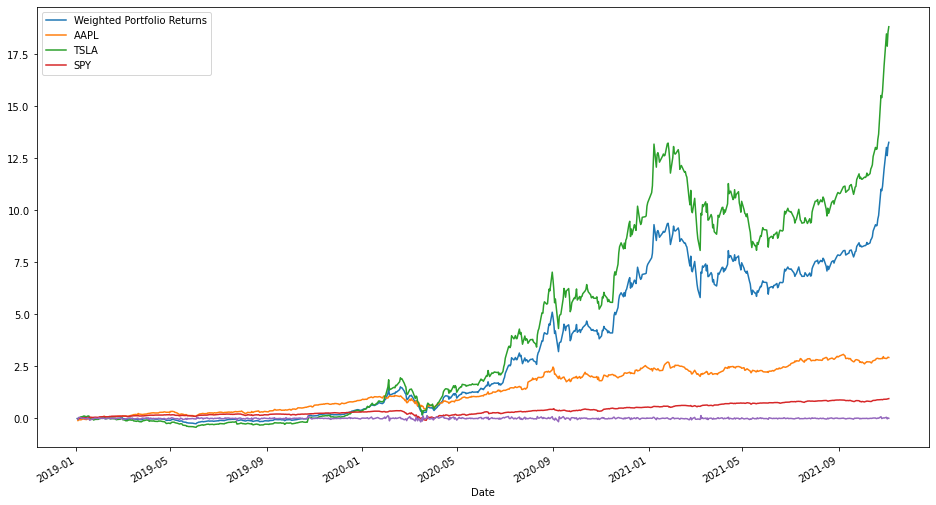

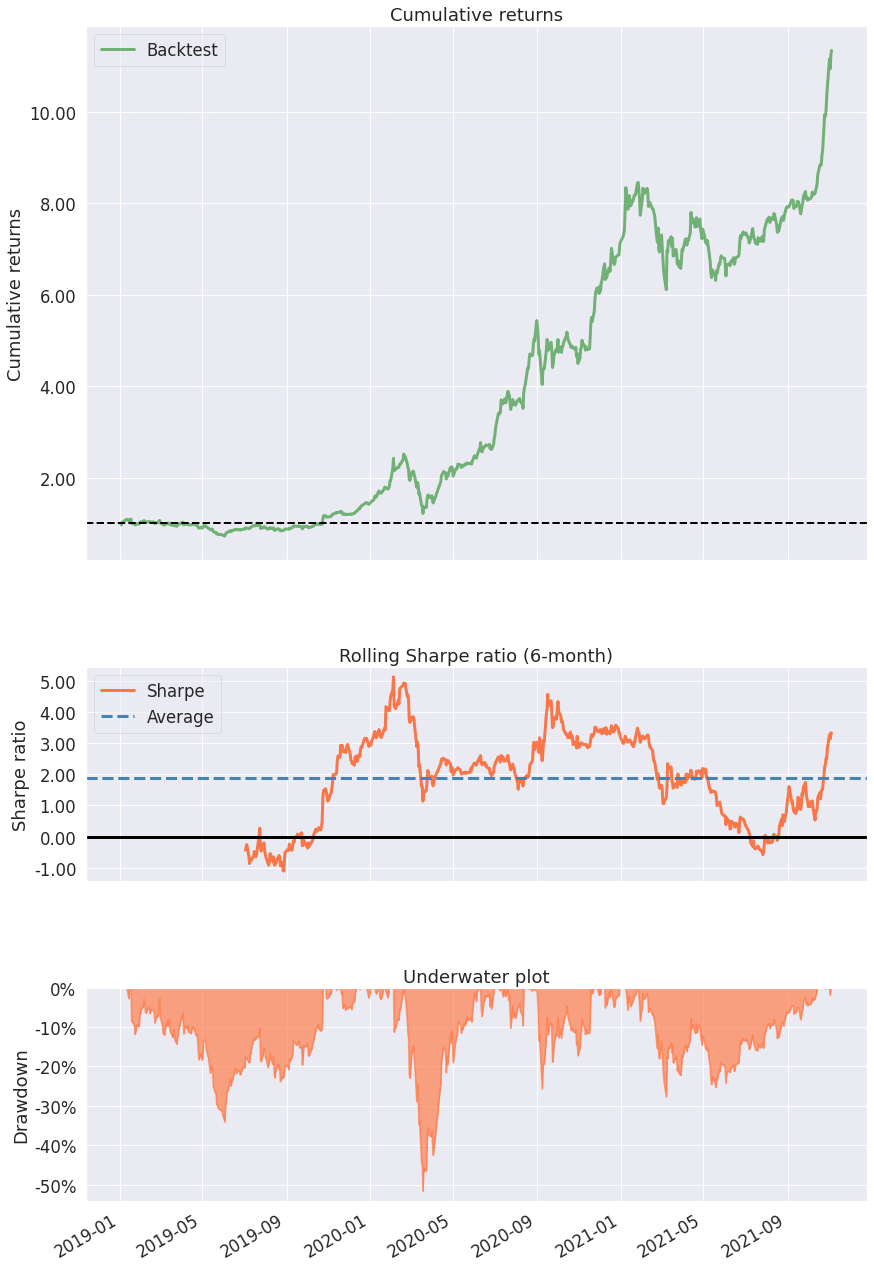

In [62]:
start_date = '2019-01-01'
end_date = '2021-11-04'
processing(start_date, end_date)

### Processing not in function

In [25]:
start_date = '2019-01-01'
end_date = '2021-11-04'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)
#Use loc method to ensure we do not consider extra days of data
panel_data = panel_data.loc['2019-01-01':'2021-11-04']
closes_1y = panel_data[['Close', 'Adj Close']]

In [26]:
closes_1y.isnull().sum()

Attributes  Symbols
Close       AAPL       0
            TSLA       0
            SPY        0
Adj Close   AAPL       0
            TSLA       0
            SPY        0
dtype: int64

Symbols,AAPL,TSLA,SPY
Date,,,
2019-01-02,NaN,NaN,NaN
2019-01-03,-0.099607,-0.031472,-0.023863
2019-01-04,-0.061170,0.024410,0.008834
2019-01-07,-0.063260,0.080098,0.016788
2019-01-08,-0.045403,0.081356,0.026341


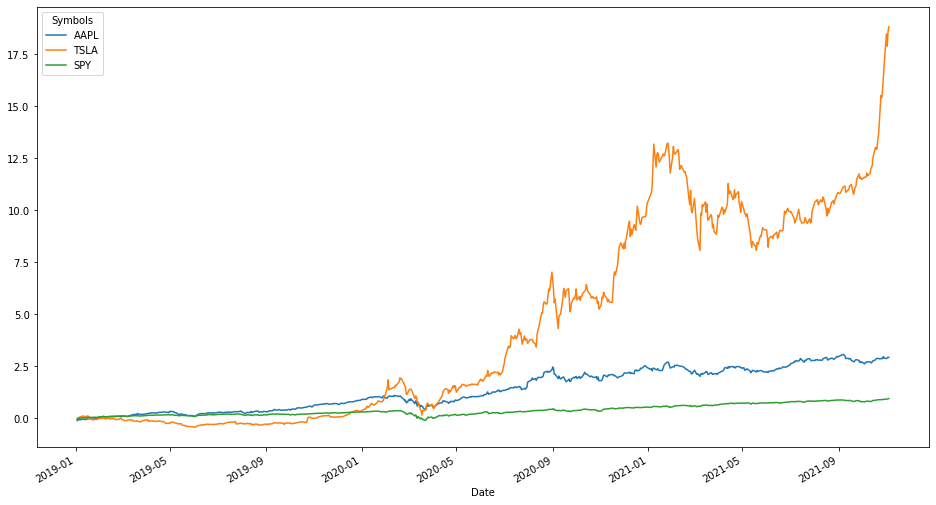

In [27]:
# Return Series

return_series_adj = (closes_1y['Adj Close'].pct_change()+ 1).cumprod() - 1
return_series_adj.plot(figsize=(16,9))

return_series_adj.head()

### Portfolio Calculations not in function

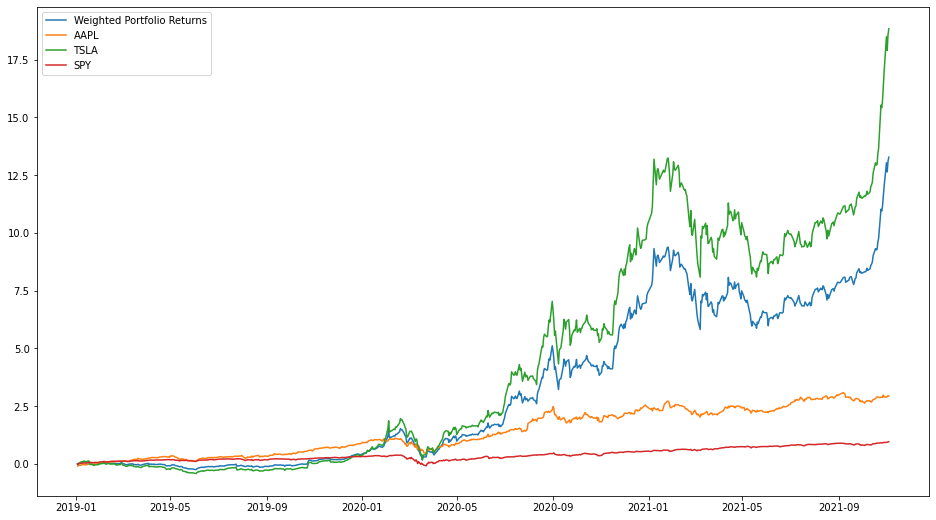

In [28]:
#portfolio returns

weights = positions_df['weights'].tolist()
weights
weighted_return_series_portfolio = weights * (return_series_adj)
#Sum the weighted returns
return_series_adj_portfolio = weighted_return_series_portfolio.sum(axis=1)

#Plot the weighted returns and individual returns on the same plot for comparison
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(return_series_adj_portfolio, label = 'Weighted Portfolio Returns')

for ticker in tickers:
    ax.plot(return_series_adj[ticker] , label = ticker)
    
ax.legend()

#### Single line plot - weighted portfolio returns and Multi-line plot - Weighted portfolio returns, AAPL, TSLA, SPY return series adj

In [ ]:
sf = return_series_adj_portfolio
return_series_adj_portfolio_df = pd.DataFrame({'Date':sf.index, 'Weighted Portfolio Returns':sf.values})
return_series_adj_portfolio_df.head()

# selected = return_series_adj.copy()
# return_series_adj_portfolio_concat = pd.concat([return_series_adj_portfolio_df, selected], ignore_index=True)
# return_series_adj_portfolio_concat

fig = px.line(return_series_adj_portfolio_df, x='Date', y='Weighted Portfolio Returns', title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()


In [ ]:
return_series_adj_portfolio_df = pd.DataFrame({'Date':return_series_adj_portfolio.index, 'Weighted portfolio returns':return_series_adj_portfolio.values})

for ticker in tickers:
    temp = return_series_adj[ticker].tolist()
    return_series_adj_portfolio_df[ticker] = temp

return_series_adj_portfolio_df

In [ ]:
# df = px.data.stocks()
fig = px.line(return_series_adj_portfolio_df, x="Date", y=return_series_adj_portfolio_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='custom tick labels')

# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y")
# fig.show()

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

### Portfolio Volatility

In [34]:
def get_volatility():
    
    #for portfolio volatility 
    return_series_close = (closes_1y['Close'].pct_change()+ 1).cumprod() - 1 
    weighted_return_series_close_portfolio = weights * (return_series_close)
    return_series_close_portfolio = weighted_return_series_close_portfolio.sum(axis=1)

    ret_portfolio = return_series_adj_portfolio.tail(1)
    print("Portfolio Return:", ret_portfolio[-1].round(3))

    vol_portfolio = np.sqrt(252) * np.log((return_series_close_portfolio+1)/(return_series_close_portfolio+1).shift(1)).std()
    print("Portfolio Volatility:", vol_portfolio.round(3))
    
    return ret_portfolio, vol_portfolio

### Check for Portfolio Analysis - Volatility


In [35]:
ret_portfolio = get_volatility()[0]
vol_portfolio = get_volatility()[1]

Portfolio Return: 13.273
Portfolio Volatility: 0.561
Portfolio Return: 13.273
Portfolio Volatility: 0.561


In [10]:
user_input = 0.50
def volatility_check(user_input, vol_portfolio, ret_portfolio):
    if vol_portfolio<=user_input:
        return 'PASS'
    else:
        return 'FAIL'
    
# volatility_check(user_input)

### Portfolio RAR - Sharpe Ratio

In [29]:
'''
Prints out average daily rate of portfolio, average risk free rate of portfolio, and Sharpe Ratio
'''

def get_sharpe_ratio():
    #assume a risk free rate of 1%. Use 0% to match results with pyfolio
    risk_free_ann_ret_rate = 0.01

    returns_ts = closes_1y['Adj Close'].pct_change().dropna()
    avg_daily_ret = returns_ts.mean()

    #create the risk free rate column
    returns_ts['RiskFree_Rate'] = risk_free_ann_ret_rate/252
    avg_rf_ret = returns_ts['RiskFree_Rate'].mean()

    #Add the excess return columns for each stock
    for ticker in tickers:
        returns_ts[f"Excess_ret_{ticker}"] = returns_ts[ticker] - returns_ts['RiskFree_Rate']

    # returns_ts.head()

    #multiply the daily pct.change() with the weights
    weighted_return_portfolio = weights * (returns_ts[tickers])
    # weighted_return_portfolio.head()

    #sum up the weighted pct returns of all the stocks in the portfolio.
    returns_portfolio = pd.DataFrame(weighted_return_portfolio.sum(axis = 1), columns = ['wt_portfolio'])
    returns_portfolio.head()

    #find the average daily return
    avg_daily_portfolio = returns_portfolio.mean()
    print("Avg daily rate for the portfolio - ", avg_daily_portfolio)

    #create a risk free annual rate column in the DF
    risk_free_ann_ret_rate1 = 0
    returns_portfolio['RiskFree_Rate'] = risk_free_ann_ret_rate1/252

    #find the average rf rate
    avg_rf_ret_portfolio = returns_portfolio['RiskFree_Rate'] .mean()
    print("Avg risk free rate for the portfolio - ", avg_rf_ret_portfolio)

    #create the excess returns column
    returns_portfolio['Excess_ret_portfolio'] = returns_portfolio['wt_portfolio'] - returns_portfolio['RiskFree_Rate']
    #use the sharpe ratio formula to find RAR

    sharpe_portfolio = ((avg_daily_portfolio - avg_rf_ret_portfolio) /returns_portfolio['Excess_ret_portfolio'].std())*np.sqrt(252)
    print("Sharpe Ratio of the Portfolio :\n", sharpe_portfolio.round(3))
    
    sharpe_value = sharpe_portfolio['wt_portfolio']
    
    return sharpe_value

### Check for Sharpe Ratio

In [30]:
sharpe_value = get_sharpe_ratio()

Avg daily rate for the portfolio -  wt_portfolio    0.003885
dtype: float64
Avg risk free rate for the portfolio -  0.0
Sharpe Ratio of the Portfolio :
 wt_portfolio    1.968
dtype: float64


In [31]:
default = 1
def sharpe_check(default):
    sharpe_value = get_sharpe_ratio()
    if sharpe_value >default:
        return 'PASS'
    else:
        return 'FAIL'
    
sharpe_check(default)

Avg daily rate for the portfolio -  wt_portfolio    0.003885
dtype: float64
Avg risk free rate for the portfolio -  0.0
Sharpe Ratio of the Portfolio :
 wt_portfolio    1.968
dtype: float64


'PASS'

### Portfolio Analysis Tearsheet

In [32]:
print(weights)

[0.10707455864175937, 0.6772458546141469, 0.21567958674409388]


Start date,2019-01-03
End date,2021-11-04
Total months,34
,Backtest
Annual return,134.8%
Cumulative returns,1034.6%
Annual volatility,49.8%
Sharpe ratio,1.97
Calmar ratio,2.61
Stability,0.92
Max drawdown,-51.7%


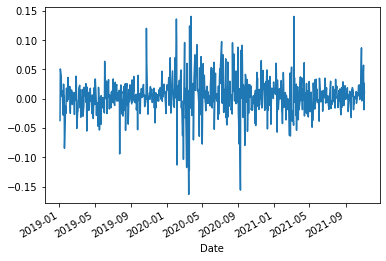

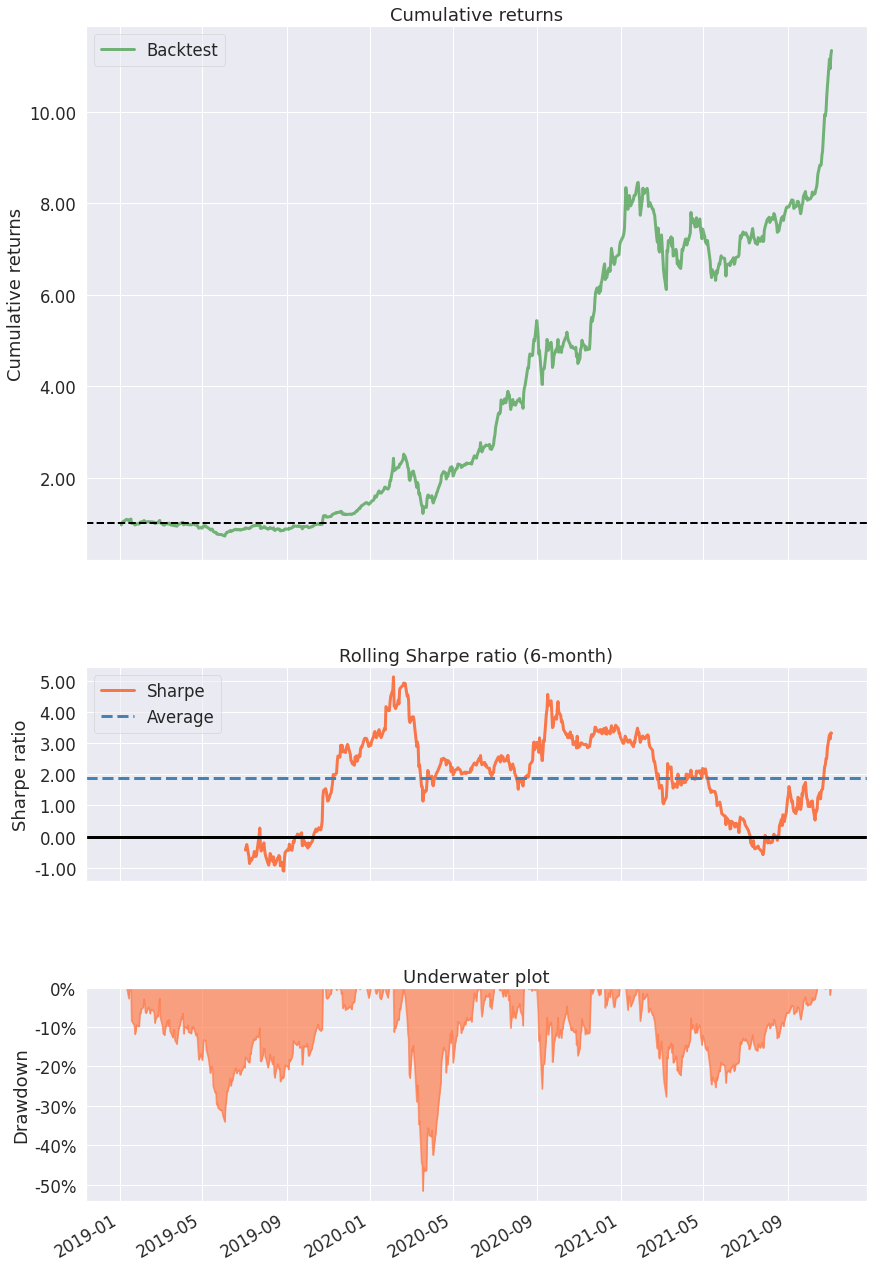

In [36]:
#keep only the first 3 columns of pct.change() from returns_ts for finding portfolio returns
returns_ts = closes_1y['Adj Close'].pct_change().dropna()

returns_ts = returns_ts[tickers]
# returns_ts.head()

#apply the weights to returns
wt_portfolio_ret = returns_ts * weights
# wt_portfolio_ret.head()

portfolio_returns1 = wt_portfolio_ret.sum(axis = 1)
# portfolio_returns1.head()

portfolio_returns1.plot()

#Create the pyfolio tear sheet
pf.create_simple_tear_sheet(portfolio_returns1)